In this notebook we will see how to embed a batch of sequences using ESM C, as well as explore its different layers

# Set up Forge client for ESM C

Grab a token from [the Forge console](https://forge.evolutionaryscale.ai/console) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.

In [ ]:
pip install --upgrade python

In [ ]:
!python3 --version

In [ ]:
pip install --upgrade pip

In [ ]:
# Install esm and other dependencies
! pip install esm
! pip install matplotlib

In [2]:
from getpass import getpass

token = getpass("Token from Forge console: ")

Token from Forge console: ········


In [3]:

from esm.sdk import client

model = client(
    model="esmc-600m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

# Set up utilities for embedding sequences

Since we're embedding more than a few sequences, we're going to use a threaded async call to Forge and let Forge take care of batching and parallelization on the backend.

In [4]:
from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

In [42]:
?ESMProtein

# Requesting a specific hidden layer

ESM C 6B's hidden states are really large, so we only allow one specific layer to be requested per API call. This also works for other ESM C models, but it is required for ESM C 6B. 
Refer to https://forge.evolutionaryscale.ai/console to find the number of hidden layers for each model. 

In [5]:
ESMC_6B_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=55)

# Load dataset

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

adk_path = "ExampleData.csv"
df = pd.read_csv(adk_path)
df = df[['sequence', "Data"]]

In [26]:
df

,sequence,Data
0,MAPTLSEQTRQLVRASVPALQKHSVAISATMCRLLFERYPETRSLC...,-0.271
1,MAPTLSEQTRQLVRASVPALQKHSVAISATMCRLLFERYPETRSLF...,-0.894
2,MAPTLSEQTRQLVRASVPALQKHSVAISATMCRLLFERYPETRSLF...,-0.453
3,MAPTLSEQTRQLVRASVPALQKHSVAISATMCRLLFERYPETRSLF...,-0.016
4,MAPTLSEQTRQLVRASVPALQKHSVAISATMCRLLFERYPETRSLG...,0.066
...,...,...
561,MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLN...,-0.791
562,MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLN...,-0.066
563,MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLN...,-0.148
564,MAPTLSEQTRQLVRASVPALQKHSVAISATMYRLLFERYPETRSLN...,-0.398


In [27]:
# You may see some error messages due to rate limits on each Forge account,
# but this will retry until the embedding job is complete
# This may take a few minutes to run
outputs = batch_embed(model, df["sequence"].tolist())

Retrying... Attempt 1 after 1.0s due to: (502, 'Failure in encode: <html>\r\n<head><title>502 Bad Gateway</title></head>\r\n<body>\r\n<center><h1>502 Bad Gateway</h1></center>\r\n</body>\r\n</html>\r\n')
Retrying... Attempt 1 after 1.0s due to: (502, 'Failure in logits: <html>\r\n<head><title>502 Bad Gateway</title></head>\r\n<body>\r\n<center><h1>502 Bad Gateway</h1></center>\r\n</body>\r\n</html>\r\n')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')

Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your da

Retrying... Attempt 4 after 8.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 4 after 8.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in

Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in

Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 4 after 8.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 3 after 4.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in

Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 4 after 8.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 4 after 8.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 1 after 1.0s due to: (429, 'Failure in encode: {"status":"error","message":"You have exceeded your daily credit limit of 10 credits."}')
Retrying... Attempt 2 after 2.0s due to: (429, 'Failure in

In [35]:
# !!only 336 sequences (out of 566) were embedded due to the model's limit so carrying out further analysis on 336 sequences
outputs_new=outputs[:336]

In [31]:
import torch

In [36]:
# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
all_mean_embeddings = [
    torch.mean(output.hidden_states, dim=-2).squeeze() for output in outputs_new
]

# now we have a list of tensors of [num_layers, hidden_size]
print("embedding shape [num_layers, hidden_size]:", all_mean_embeddings[0].shape)

embedding shape [num_layers, hidden_size]: torch.Size([37, 1152])


# Examine the performance of different layer embeddings

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the [rand index](https://en.wikipedia.org/wiki/Rand_index), a measure of the quality of the clustering.

In [47]:
# matching fitness score of 336 sequences that were embeddded
df3=df['Data'][:336]

In [48]:
df3

0     -0.271
1     -0.894
2     -0.453
3     -0.016
4      0.066
       ...  
331   -0.269
332   -0.398
333   -0.006
334   -0.031
335   -0.641
Name: Data, Length: 336, dtype: float64

In [37]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3

In [61]:
def plot_embeddings_at_layer(all_mean_embeddings: torch.Tensor, layer_idx: int):
    stacked_mean_embeddings = torch.stack(
        [embedding[layer_idx, :] for embedding in all_mean_embeddings]
    ).numpy()

    # project all the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    pca.fit(stacked_mean_embeddings)
    projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

    # compute kmeans purity as a measure of how good the clustering is
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_mean_embeddings
    )
    rand_index = adjusted_rand_score(df3, kmeans.labels_)

    # plot the clusters
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=df3,
    )
    plt.title(
        f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}"
    )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(title='Data', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

C:\Users\Sakshi\Downloads\thesis_janssen\code\py3.10env\lib\site-packages\sklearn\metrics\cluster\_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


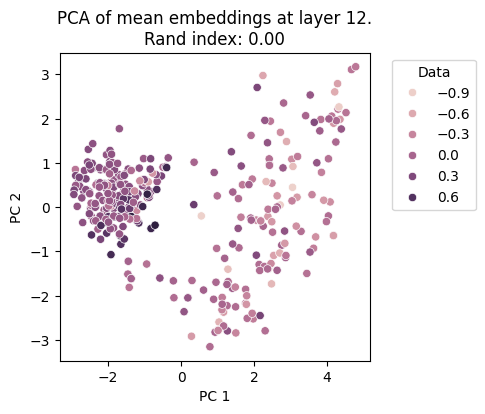

In [62]:
#plot_embeddings_at_layer(all_mean_embeddings, layer_idx=30)
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=12)

We see that the top principal components of layer 12 separate structural classes better than that of layer 30. Embed away! And keep in mind that different layers may be better or worse for your particular use-case.